# Plot WOCE Transects

This notebook is based on a script provided by Chris Chapman to plot WOCE transects from ACCESS-OM2 runs, and to compare with observations (gridded WOA13).

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [4]:
## To implement, use:
## dask-scheduler
## dask-worker tcp://10.0.64.18:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
client = Client('tcp://10.0.64.18:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.18:8786 Dashboard: http://10.0.64.18:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [5]:
KELVIN_TO_CELSIUS = -273.15

PLOT_BIAS = True


MIN_SALT   = 33.5
MAX_SALT   = 36

if PLOT_BIAS:
    MIN_TEMP_BIAS = -2.0
    MAX_TEMP_BIAS =  2.0

    MIN_SALT_BIAS = -1.0
    MAX_SALT_BIAS =  1.0

In [6]:
#==========================================================================#
#Set up the domain limits, colorbar limits, all that stuff, for the
#individual transects 
#==========================================================================#
transect_name_list = ['SR3','P16','A16','I08-09']                 ##'SR1',
transect_lons_list = [140,-150,-25,95]                            ##-65,
transect_lat_limits_list = [[-67,-42],[-76,61],[-75.01,70],[-65,15.1]] ##[-65,-55],
MIN_TEMPERATURE          = [-2,-2,-2,-2]                          ##-2,
MAX_TEMPERATURE          = [13,28,28,28]                          ##7 ,



In [7]:
#==========================================================================#
#Set labels and the cycle lengths for the individual experiments 
#==========================================================================#

labels  = ['(a) ACCESS-OM2','(b) ACCESS-OM2','(c) ACCESS-OM2-025','(d) ACCESS-OM2-025','(e) ACCESS-OM2-01', '(f) ACCESS-OM2-01','(g) WOA13','(h) WOA13']
IAF_CYCLE_LENGTH         = [12,34,150]  ## FIXME - 3rd entry should be 150!!

output_figure_path = './'


MAX_DEPTH = 4500

experiments = ['1deg_jra55v13_iaf_spinup1_B1','025deg_jra55v13_iaf_gmredi6','01deg_jra55v13_iaf']
#experiments = [ '1deg_jra55v13_iaf_spinup1_A','1deg_jra55v13_iaf_spinup1_A','1deg_jra55v13_iaf_spinup1_A']
Nexp = len(experiments)

observations_path     = '/home/157/amh157/v45/amh157/COSIMA_Paper'
observation_file_name = 'WOA13_temperature_salinity_1985_2013_remap.nc'

temperature_transect = []
salt_transect        = [] 

MAX_LON_MODEL =   79.5
MIN_LON_MODEL = -279.5

xticks = np.arange(-75,75.1,15)
xtick_labels = []
for i_tick in range(xticks.size):
    if xticks[i_tick]<0:
        xtick_labels.append(str(int(abs(xticks[i_tick]))) + r'$^{\circ}$S')
    elif xticks[i_tick]>0:
        xtick_labels.append(str(int(xticks[i_tick])) + r'$^{\circ}$N')
    else:
        xtick_labels.append(str(int(xticks[i_tick])) + r'$^{\circ}$')



Plotting transect:  SR3
-219.0
Experiment :  1deg_jra55v13_iaf_spinup1_B1
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Experiment :  025deg_jra55v13_iaf_gmredi6
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Experiment :  01deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


KilledWorker: ('open_dataset-8a74a2e7-ffbd-445b-bd79-ef1525f59d86', 'tcp://10.0.64.18:35944')

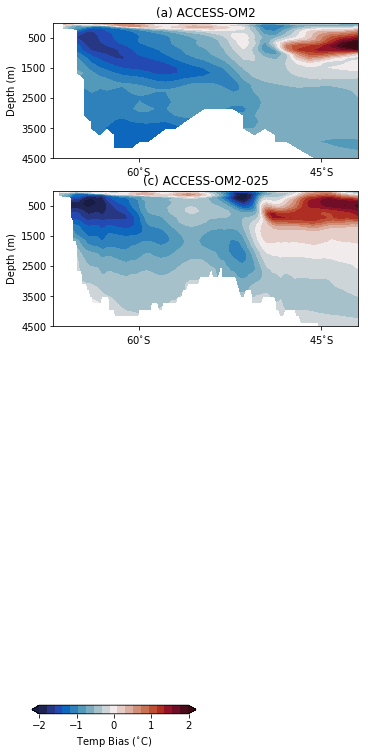

In [9]:
for i_transect in range(0,len(transect_name_list)):
    transect_name = transect_name_list[i_transect]
    transect_lon  = transect_lons_list[i_transect]
    print('Plotting transect: ', transect_name_list[i_transect])

    main_label    = r'Transect ' + transect_name + str(transect_lon)

    if transect_lon>MAX_LON_MODEL:
        transect_lon = (transect_lon-MAX_LON_MODEL) + MIN_LON_MODEL  #Model fields go from -280 to 80, so we need to take into accound the shift
        print(transect_lon)
    #END if transect_lon>MAX_LON_MODEL
   
    observation_dataset = xr.open_dataset(os.path.join(observations_path,observation_file_name),autoclose=False)
    temperature_obs     = observation_dataset['temperature']
    salt_obs            = observation_dataset['salinity']

    temperature_transect_obs = temperature_obs.sel(xt_ocean=transect_lon,method='nearest')
    salt_transect_obs        = salt_obs.sel(xt_ocean=transect_lon,method='nearest')
    
    temperature_transect_obs = temperature_transect_obs.rename({'depth':'st_ocean'})
    salt_transect_obs = salt_transect_obs.rename({'depth':'st_ocean'})
    
    #===============================================#
    # Plot Temperature Sections
    #===============================================#

    fig = plt.figure(i_transect+1,figsize=(12,12))
    plt.subplots_adjust(bottom=0.14,hspace=0.24)
    
    counter  = 1
    #for i_exp in range(0,Nexp):
    for ekey in exptdata.exptdict.keys():
        
        expt = exptdata.exptdict[ekey]['expt']
        n_files = exptdata.exptdict[ekey]['n_files']
        time_units = exptdata.exptdict[ekey]['time_units']
        offset = exptdata.exptdict[ekey]['offset']
                
        print('Experiment : ', expt)
        if ekey == '01deg':
            temperature = xr.open_dataset('/g/data/v45/amh157/COSIMA_Paper/ocean_temp_access-om2-01_1993-2017.nc',autoclose=False).temp
            temperature = temperature.sel(xt_ocean=transect_lon,method='nearest').mean('time') + KELVIN_TO_CELSIUS
        else:
            temperature = cc.get_nc_variable(expt,'ocean.nc','temp',chunks={'xt_ocean':5},n=n_files,time_units=time_units, offset=offset)
            temperature = temperature.sel(xt_ocean=transect_lon,method='nearest').sel(time=slice(tstart,tend)).mean('time') + KELVIN_TO_CELSIUS

        if PLOT_BIAS:
      
            temperature_obs_on_model_grid = temperature_transect_obs.interp_like(temperature)
       
            temperature = temperature - temperature_obs_on_model_grid
            color_bar_limits = [MIN_TEMP_BIAS,MAX_TEMP_BIAS]
            colormap         = cm.cm.balance
            cbar_label       = r'Temp Bias ($^{\circ}$C)'
        else:
            color_bar_limits = [MIN_TEMPERATURE[i_transect],MAX_TEMPERATURE[i_transect]]
            colormap         = cm.cm.thermal
            cbar_label       = r'Temperature ($^{\circ}$C)'
            
        ax = fig.add_subplot(4,2,2*counter-1)
        cs_temp = ax.contourf(temperature['yt_ocean'],-temperature['st_ocean'],temperature,np.linspace(color_bar_limits[0],color_bar_limits[1],20),cmap=colormap,extend='both')

        #=================================# 
        #Set up the axes ticks and labels
        #=================================# 
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlim(transect_lat_limits_list[i_transect])
 
        ax.set_yticks(np.arange(-MAX_DEPTH,0.1,1000))
        ax.set_yticklabels(np.arange(MAX_DEPTH,0.1,-1000).astype(np.int))
        ax.set_ylim([-MAX_DEPTH,0])
        ax.set_ylabel(r"Depth (m)") 
        #=================================# 
        #Colorbar
        #=================================# 
        if counter == 2:
            ax1 = plt.axes([0.1,0.08,0.19,0.01])
            n_colorbar_ticks = 5
            cbar = fig.colorbar(cs_temp,cax=ax1,orientation='horizontal',ticks=np.linspace(color_bar_limits[0],color_bar_limits[1],n_colorbar_ticks))
            cbar.set_label(cbar_label)

        #=================================#
        #Annotation
        #=================================#
        ax.set_title(labels[2*(counter-1)])
        
        counter = counter + 1


    ax = fig.add_subplot(427)
    cs_temp = ax.contourf(temperature_transect_obs['yt_ocean'],-temperature_transect_obs['st_ocean'],temperature_transect_obs,np.linspace(MIN_TEMPERATURE[i_transect],MAX_TEMPERATURE[i_transect],20),cmap=cm.cm.thermal,extend='both')
    ax2 = plt.axes([0.3,0.08,0.19,0.01])
    n_colorbar_ticks = 7
    cbar = fig.colorbar(cs_temp,cax=ax2,orientation='horizontal',ticks=np.linspace(MIN_TEMPERATURE[i_transect],MAX_TEMPERATURE[i_transect],n_colorbar_ticks))
    cbar.set_label('Temperature ($^{\circ}C$)')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim(transect_lat_limits_list[i_transect])
    ax.set_xlabel("Latitude")

    ax.set_yticks(np.arange(-MAX_DEPTH,0.1,1000))
    ax.set_yticklabels(np.arange(MAX_DEPTH,0.1,-1000).astype(np.int))
    ax.set_ylim([-MAX_DEPTH,0])
    ax.set_ylabel(r"Depth (m)")

    #=================================# 
    # Annotations
    #=================================# 
    ax.set_title(labels[6])

    #===============================================#
    # Plot Salinity Sections
    #===============================================#

    counter  = 1
    for ekey in exptdata.exptdict.keys():
        
        expt = exptdata.exptdict[ekey]['expt']
        n_files = exptdata.exptdict[ekey]['n_files']
        time_units = exptdata.exptdict[ekey]['time_units']
        offset = exptdata.exptdict[ekey]['offset']
        
        print('Experiment : ', expt)

        salt  = cc.get_nc_variable(expt,'ocean.nc','salt',chunks={'xt_ocean':5},n=n_files,time_units=time_units, offset=offset)
        salt  = salt.sel(xt_ocean=transect_lon,method='nearest').sel(time=slice(tstart,tend)).mean('time')
        
        if PLOT_BIAS:
      
            salt_obs_on_model_grid        = salt_transect_obs.interp_like(salt)
            salt                          = salt - salt_obs_on_model_grid
            color_bar_limits = [MIN_SALT_BIAS,MAX_SALT_BIAS]
            colormap         = cm.cm.balance
            cbar_label       = r'Salt Bias (g/kg)'
        else:
            color_bar_limits = [MIN_SALT,MAX_SALT]
            colormap         = cm.cm.haline
            cbar_label       = r'Salinity (g/kg)'

        ax = fig.add_subplot(4,2,2*counter)
        cs_salt = ax.contourf(salt['yt_ocean'],-salt['st_ocean'],salt,np.linspace(color_bar_limits[0],color_bar_limits[1],20),cmap=colormap,extend='both')

        #=================================# 
        # Set up the axes ticks and labels
        #=================================# 
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlim(transect_lat_limits_list[i_transect])
 
        ax.set_yticks(np.arange(-MAX_DEPTH,0.1,1000))
        ax.set_yticklabels(np.arange(MAX_DEPTH,0.1,-1000).astype(np.int))
        ax.set_ylim([-MAX_DEPTH,0]) 
                
        ax.set_title(labels[2*(counter-1)+1])
        
        #=================================# 
        # Colorbar
        #=================================# 
        if counter == 2:
            ax3 = plt.axes([0.53,0.08,0.19,0.01])
            n_colorbar_ticks = 5
            cbar = fig.colorbar(cs_salt,cax=ax3,orientation='horizontal',ticks=np.linspace(color_bar_limits[0],color_bar_limits[1],n_colorbar_ticks))
            cbar.set_label(cbar_label)

        counter = counter + 1
        
    ax = fig.add_subplot(428)
    cs_salt = ax.contourf(salt_transect_obs['yt_ocean'],-salt_transect_obs['st_ocean'],salt_transect_obs,np.linspace(MIN_SALT,MAX_SALT,20),cmap=cm.cm.haline,extend='both')
    

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim(transect_lat_limits_list[i_transect])
    ax.set_ylim([-MAX_DEPTH,0])
    ax.set_xlabel("Latitude")

    ax4 = plt.axes([0.74,0.08,0.19,0.01])
    n_colorbar_ticks = 6
    cbar = fig.colorbar(cs_salt,cax=ax4,orientation='horizontal',ticks=np.linspace(MIN_SALT,MAX_SALT,n_colorbar_ticks))
    cbar.set_label('Salinity (g/kg)')

    ax.set_title(labels[7])


    output_figure_path = './'
    figure_file_name   = 'Model_vs_WOA13_Temp_Salt_' + transect_name
    if PLOT_BIAS:
        figure_file_name = figure_file_name + '_bias'

    savefigure(output_figure_path + figure_file_name)